## Structural Identifiability Analysis for Case Study 0 (With Parameter Fixing)

##Install & import

In [ ]:
!pip install casadi --quiet
!pip install pymoo --quiet
import casadi as ca
import numpy as np
from itertools import combinations
from scipy.integrate import solve_ivp
from scipy.linalg import svd
import time
import matplotlib.pyplot as plt
from pymoo.core.problem import Problem
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize
from pymoo.termination import get_termination
from pymoo.core.sampling import Sampling
from itertools import combinations

## Fixing Parameters: Option 1

First option: A function that checks for S.I. sequentially, starting from the base case (no fixed parameters). Once it finds a suitable solution (which is measured by a threshold given by the minimum singular value), it finishes checking the combinations with the same amount of fixed parameters, thus finding the set of the minimum number of parameters fixed for a set minimum singular value.

In [ ]:
# === General Configuration ===
theta_nom = np.array([0.5, 2.0, 0.6, 0.01, 2.0, 1.0])  # mu, Ks, Y, Kd, b1, b2
param_names = ['mu', 'Ks', 'Y', 'Kd', 'b1', 'b2']
Nth = len(theta_nom)        # Number of total parameters
Nt = 10                     # Number of time points
Tf = 5.0                    # Final integration time
t_eval = np.linspace(0, Tf, Nt)
nx = 2                      # Number of states
NExp = 50                  # Monte Carlo simulations
sigma_min_threshold = 1e-3 # Identifiability threshold

# === Model Builder ===
def build_model(free_indices, theta_nom):
    """
    Constructs a CasADi model with given free parameters.
    """
    n_free = len(free_indices)
    theta_free = ca.MX.sym("theta", n_free)
    theta_total = [0] * Nth

    # Create full parameter vector with fixed + symbolic values
    for i in range(Nth):
        if i in free_indices:
            theta_total[i] = theta_free[free_indices.index(i)]
        else:
            theta_total[i] = theta_nom[i]

    mu, Ks, Y, Kd, b1, b2 = theta_total

    # Define symbolic state vector and ODEs
    x = ca.MX.sym("x", nx)
    xdot = ca.vertcat(
        (mu * x[1] * x[0]) / (Ks + x[1]) - Kd * x[0],
        -(mu * x[1] * x[0]) / ((Ks + x[1]) * Y)
    )

    x0 = ca.vertcat(b1, b2)
    dx0 = ca.jacobian(x0, theta_free)
    Jx = ca.jacobian(xdot, x)
    Jth = ca.jacobian(xdot, theta_free)

    return {
        'f_rhs': ca.Function("rhs", [x, theta_free], [xdot]),
        'f_Jx': ca.Function("Jx", [x, theta_free], [Jx]),
        'f_Jth': ca.Function("Jth", [x, theta_free], [Jth]),
        'f_x0': ca.Function("x0", [theta_free], [x0]),
        'f_dx0': ca.Function("dx0", [theta_free], [dx0]),
        'idx_libres': free_indices
    }

# === Simulation with sensitivities ===
def simulate_once(theta_val_free, model):
    """
    Integrates the model and its sensitivities with respect to free parameters.
    """
    x0_val = model['f_x0'](theta_val_free).full().flatten()
    dx0_val = model['f_dx0'](theta_val_free).full().reshape((nx, len(theta_val_free)))
    x_ext = np.concatenate([x0_val, dx0_val.flatten()])

    def rhs_meta(t, x_ext):
        x = x_ext[:nx]
        dx_dth = x_ext[nx:].reshape(nx, len(theta_val_free))
        A = model['f_Jx'](x, theta_val_free).full()
        B = model['f_Jth'](x, theta_val_free).full()
        dx = model['f_rhs'](x, theta_val_free).full().flatten()
        d_dx_dth = A @ dx_dth + B
        return np.concatenate([dx, d_dx_dth.flatten()])

    sol = solve_ivp(rhs_meta, [0, Tf], x_ext, t_eval=t_eval, method='BDF', rtol=1e-12, atol=1e-12)

    if not sol.success:
        raise RuntimeError("❌ Integration failed")

    x_out = sol.y[:nx].T
    dx_dth_out = sol.y[nx:].T.reshape(Nt, nx, len(theta_val_free))
    return x_out, dx_dth_out

# === Sensitivity matrix (relative) ===
def compute_dydth(x_out, dx_dth_out, theta_val_free):
    """
    Computes the relative sensitivity matrix for observable y = x1.
    """
    y_out = x_out[:, 0]
    dydth = dx_dth_out[:, 0, :]

    if np.any(y_out == 0):
        raise ValueError("❌ y_out contains zero values → division undefined")

    dydth_rel = dydth * theta_val_free.reshape(1, -1) / y_out.reshape(-1, 1)
    return dydth_rel

# === Evaluate a parameter-fixing combination ===
def evaluate_combination(fixed_idx, theta_nom, NExp=50):
    """
    Performs Monte Carlo simulation and sensitivity analysis
    for a specific combination of fixed parameters.
    """
    free_idx = [i for i in range(Nth) if i not in fixed_idx]
    model = build_model(free_idx, theta_nom)

    # Monte Carlo sampling
    THETA = np.random.uniform(0.5, 1.5, size=(NExp, Nth)) * theta_nom
    THETA[0] = theta_nom.copy()

    sigma_min_list = []
    v_last_list = []

    for k in range(NExp):
        theta_k = THETA[k].copy()
        theta_k[fixed_idx] = theta_nom[fixed_idx]
        theta_free = theta_k[free_idx]
        theta_nom_free = theta_nom[free_idx]

        try:
            x_out, dx_dth_out = simulate_once(theta_free, model)
            dydth_rel = compute_dydth(x_out, dx_dth_out, theta_nom_free)
            if np.any(np.isnan(dydth_rel)) or np.any(np.isinf(dydth_rel)):
                raise ValueError("NaNs or Infs in sensitivity matrix")
            _, S, Vh = svd(dydth_rel, full_matrices=False)
            sigma_min_list.append(S[-1])
            v_last_list.append(np.abs(Vh[-1]))
        except Exception as e:
            print(f"❌ Error for combination {fixed_idx}: {e}")
            continue

    if len(sigma_min_list) == 0:
        return None

    sigma_min = np.min(sigma_min_list)
    v_last_array = np.array(v_last_list)
    mean_v = np.mean(v_last_array, axis=0)
    std_v = np.std(v_last_array, axis=0)

    print(f"🔍 Fix {[param_names[i] for i in fixed_idx]} → σ_min = {sigma_min:.2e}")

    return {
        'fixed': [param_names[i] for i in fixed_idx],
        'free': [param_names[i] for i in free_idx],
        'sigma_min': sigma_min,
        'mean_v': mean_v,
        'std_v': std_v
    }

# === Identifiability Analysis: Loop through all combinations ===
results = []
start_time1 = time.perf_counter()
for r in range(Nth + 1):  # Try from 0 to Nth parameters fixed
    candidates_r = []
    for comb in combinations(range(Nth), r):
        res = evaluate_combination(list(comb), theta_nom, NExp=NExp)
        if res is not None:
            candidates_r.append(res)
    if any(r['sigma_min'] >= sigma_min_threshold for r in candidates_r):
        results.extend(candidates_r)
        print(f"\n🛑 Analysis stopped at r = {r} fixed parameters.")
        break
    results.extend(candidates_r)
elapsed_time1 = time.perf_counter() - start_time1
print(f"\nSimulation time: {elapsed_time1:.3e} s.")
# === Report the best results ===
valid_results = [r for r in results if r['sigma_min'] >= sigma_min_threshold]

if valid_results:
    min_fixed = min(len(r['fixed']) for r in valid_results)
    best_results = [r for r in valid_results if len(r['fixed']) == min_fixed]
    print(f"\n✅ Optimal combinations (σ_min ≥ {sigma_min_threshold:.0e}):")
    for r in best_results:
        print(f"🔍 Fix {r['fixed']} → σ_min = {r['sigma_min']:.2e}")
else:
    print(f"\n❌ No valid combination found with σ_min ≥ {sigma_min_threshold:.0e}")


🔍 Fix [] → σ_min = 1.93e-17
🔍 Fix ['mu'] → σ_min = 6.70e-17
🔍 Fix ['Ks'] → σ_min = 7.09e-05
🔍 Fix ['Y'] → σ_min = 1.26e-04
🔍 Fix ['Kd'] → σ_min = 2.26e-17
🔍 Fix ['b1'] → σ_min = 1.21e-17
🔍 Fix ['b2'] → σ_min = 1.17e-05
🔍 Fix ['mu', 'Ks'] → σ_min = 1.11e-03
🔍 Fix ['mu', 'Y'] → σ_min = 1.32e-03
🔍 Fix ['mu', 'Kd'] → σ_min = 3.04e-16
🔍 Fix ['mu', 'b1'] → σ_min = 9.90e-17
🔍 Fix ['mu', 'b2'] → σ_min = 1.06e-03
🔍 Fix ['Ks', 'Y'] → σ_min = 8.97e-04
🔍 Fix ['Ks', 'Kd'] → σ_min = 7.08e-04
🔍 Fix ['Ks', 'b1'] → σ_min = 1.35e-04
🔍 Fix ['Ks', 'b2'] → σ_min = 8.44e-05
🔍 Fix ['Y', 'Kd'] → σ_min = 3.30e-04
🔍 Fix ['Y', 'b1'] → σ_min = 7.57e-05
🔍 Fix ['Y', 'b2'] → σ_min = 1.16e-03
🔍 Fix ['Kd', 'b1'] → σ_min = 4.09e-17
🔍 Fix ['Kd', 'b2'] → σ_min = 9.32e-04
🔍 Fix ['b1', 'b2'] → σ_min = 9.76e-05

🛑 Analysis stopped at r = 2 fixed parameters.

Simulation time: 1.154e+02 s.

✅ Optimal combinations (σ_min ≥ 1e-03):
🔍 Fix ['mu', 'Ks'] → σ_min = 1.11e-03
🔍 Fix ['mu', 'Y'] → σ_min = 1.32e-03
🔍 Fix ['mu', 'b2'] → σ

It is pretty slow but serves as a basis for the analysis

## Fixing Parameters: Option 2

Second Option: A function that uses the mean value of the last singular vector as information for which parameters to fix, prioritizing the combinations that include non-determinable parameters as fixed.

In [ ]:
# === General Configuration ===
theta_nom = np.array([0.5, 2.0, 0.6, 0.01, 2.0, 1.0])  # mu, Ks, Y, Kd, b1, b2
param_names = ['mu', 'Ks', 'Y', 'Kd', 'b1', 'b2']
Nth = len(theta_nom)
Nt = 10
Tf = 5.0
t_eval = np.linspace(0, Tf, Nt)
nx = 2
NExp = 50
sigma_min_threshold = 1e-3

# === Model Constructor ===
def construct_model(free_idx, theta_nom):
    n_free = len(free_idx)
    theta_free = ca.MX.sym("theta", n_free)
    theta_total = [0]*Nth
    for i in range(Nth):
        if i in free_idx:
            theta_total[i] = theta_free[free_idx.index(i)]
        else:
            theta_total[i] = theta_nom[i]
    mu, Ks, Y, Kd, b1, b2 = theta_total
    x = ca.MX.sym("x", nx)
    xdot = ca.vertcat(
        (mu * x[1] * x[0]) / (Ks + x[1]) - Kd * x[0],
        -(mu * x[1] * x[0]) / ((Ks + x[1]) * Y)
    )
    x0 = ca.vertcat(b1, b2)
    dx0 = ca.jacobian(x0, theta_free)
    Jx = ca.jacobian(xdot, x)
    Jth = ca.jacobian(xdot, theta_free)
    return {
        'f_rhs': ca.Function("rhs", [x, theta_free], [xdot]),
        'f_Jx': ca.Function("Jx", [x, theta_free], [Jx]),
        'f_Jth': ca.Function("Jth", [x, theta_free], [Jth]),
        'f_x0': ca.Function("x0", [theta_free], [x0]),
        'f_dx0': ca.Function("dx0", [theta_free], [dx0]),
        'idx_libres': free_idx
    }

# === Simulate model and sensitivities ===
def simulate_once(theta_val_free, model):
    x0_val = model['f_x0'](theta_val_free).full().flatten()
    dx0_val = model['f_dx0'](theta_val_free).full().reshape((nx, len(theta_val_free)))
    x_ext = np.concatenate([x0_val, dx0_val.flatten()])
    def rhs_meta(t, x_ext):
        x = x_ext[:nx]
        dx_dth = x_ext[nx:].reshape(nx, len(theta_val_free))
        A = model['f_Jx'](x, theta_val_free).full()
        B = model['f_Jth'](x, theta_val_free).full()
        dx = model['f_rhs'](x, theta_val_free).full().flatten()
        d_dx_dth = A @ dx_dth + B
        return np.concatenate([dx, d_dx_dth.flatten()])
    sol = solve_ivp(rhs_meta, [0, Tf], x_ext, t_eval=t_eval, method='BDF', rtol=1e-12, atol=1e-12)
    if not sol.success:
        raise RuntimeError("❌ Integration failed")
    x_out = sol.y[:nx].T
    dx_dth_out = sol.y[nx:].T.reshape(Nt, nx, len(theta_val_free))
    return x_out, dx_dth_out

# === Compute relative sensitivity matrix ===
def compute_dydth(x_out, dx_dth_out, theta_val_free):
    y_out = x_out[:, 0]
    dydth = dx_dth_out[:, 0, :]
    if np.any(y_out == 0):
        raise ValueError("❌ y_out contains zero → division undefined")
    dydth_rel = dydth * theta_val_free.reshape(1, -1) / y_out.reshape(-1, 1)
    return dydth_rel

# === Evaluate a given combination of fixed parameters ===
def evaluate_combination(fixed_idx, theta_nom, NExp=50):
    free_idx = [i for i in range(Nth) if i not in fixed_idx]
    model = construct_model(free_idx, theta_nom)
    THETA = np.random.uniform(0.5, 1.5, size=(NExp, Nth)) * theta_nom
    THETA[0] = theta_nom.copy()
    sigma_min_list = []
    v_last_list = []
    for k in range(NExp):
        theta_k = THETA[k].copy()
        theta_k[fixed_idx] = theta_nom[fixed_idx]
        theta_free = theta_k[free_idx]
        theta_noms = theta_nom[free_idx]
        try:
            x_out, dx_dth_out = simulate_once(theta_free, model)
            dydth_rel = compute_dydth(x_out, dx_dth_out, theta_noms)
            if np.any(np.isnan(dydth_rel)) or np.any(np.isinf(dydth_rel)):
                raise ValueError("NaNs or Infs in sensitivity matrix")
            _, S, Vh = svd(dydth_rel, full_matrices=False)
            sigma_min_list.append(S[-1])
            v_last_list.append(np.abs(Vh[-1]))
        except Exception as e:
            print(f"❌ Error for combination {fixed_idx}: {e}")
            continue
    if len(sigma_min_list) == 0:
        return None
    sigma_min = np.min(sigma_min_list)
    v_last_array = np.array(v_last_list)
    mean_v = np.mean(v_last_array, axis=0)
    std_v = np.std(v_last_array, axis=0)
    print(f"🔍 Fix {[param_names[i] for i in fixed_idx]} → σ_min = {sigma_min:.2e}")
    return {
        'fixed': [param_names[i] for i in fixed_idx],
        'free': [param_names[i] for i in free_idx],
        'fixed_idx': fixed_idx,
        'sigma_min': sigma_min,
        'mean_v': mean_v,
        'std_v': std_v
    }

# === Hierarchical search based on v_last priority ===
def hierarchical_search_vlast(theta_nom, evaluate_combination, sigma_min_threshold=1e-3, NExp=50):
    Nth = len(theta_nom)
    print("🎯 Initial analysis with all parameters free...")
    res0 = evaluate_combination([], theta_nom, NExp)
    if res0 is None:
        raise RuntimeError("Initial analysis with all parameters free failed.")

    v_base = np.abs(res0['mean_v'])
    priority_order = list(np.argsort(-v_base))  # descending order
    contribution_threshold = 1e-2
    priority_order = [i for i in priority_order if v_base[i] > contribution_threshold]

    history = set()
    results = []

    for num_fixed in range(1, Nth + 1):
        new_combinations = []
        if num_fixed == 1:
            for i in priority_order:
                new_combinations.append((i,))
        else:
            previous = [tuple(sorted(res['fixed_idx'])) for res in results if len(res['fixed_idx']) == num_fixed - 1]
            for comb in previous:
                remaining = [i for i in priority_order if i not in comb]
                for new_param in remaining:
                    new_comb = tuple(sorted(comb + (new_param,)))
                    new_combinations.append(new_comb)

        new_combinations = [c for c in new_combinations if c not in history]
        if not new_combinations:
            break

        for comb in new_combinations:
            res = evaluate_combination(list(comb), theta_nom, NExp)
            if res is not None:
                res['fixed_idx'] = list(comb)
                results.append(res)
                if res['sigma_min'] >= sigma_min_threshold:
                    print(f"\n✅ Threshold reached by fixing {res['fixed']} → σ_min = {res['sigma_min']:.2e}")
                    return results
            history.add(comb)

    print("\n❌ No combination reached the σ_min threshold.")
    return results

# === Execute search ===
start_time2 = time.perf_counter()
results = hierarchical_search_vlast(theta_nom, evaluate_combination)
elapsed_time2 = time.perf_counter() - start_time2
print(f"\nSimulation time: {elapsed_time2:.3e} s.")


🎯 Initial analysis with all parameters free...
🔍 Fix [] → σ_min = 1.55e-17
🔍 Fix ['b2'] → σ_min = 1.65e-05
🔍 Fix ['Y'] → σ_min = 4.00e-05
🔍 Fix ['Ks'] → σ_min = 5.08e-05
🔍 Fix ['Y', 'b2'] → σ_min = 1.27e-03

✅ Threshold reached by fixing ['Y', 'b2'] → σ_min = 1.27e-03

Simulation time: 2.695e+01 s.


This iteration is faster than its predecessor, while sacrificing the "optimal" approach for a more requirement-based search where a sufficient solution is reached

## Fixing Parameters: Option 3 Genetic Algorithm application

Utilizing pymoo's Genetic Algorithm, this code acts as a branching search algorithm for a sufficient solution.

🔍 Fix [] → σ_min = 2.46e-17
🔍 Fix ['mu', 'Y', 'b2'] → σ_min = 2.61e-02
✅ New optimum: 3 fixed → ['mu', 'Y', 'b2']
🔍 Fix ['b1'] → σ_min = 2.76e-17
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |        3 |  6.666680E+05 |  3.0000000000
     2 |        6 |  6.666680E+05 |  3.0000000000
🔍 Fix ['Y'] → σ_min = 6.28e-05
     3 |        9 |  6.666680E+05 |  3.0000000000
🔍 Fix ['mu', 'Y'] → σ_min = 1.40e-03
✅ New optimum: 2 fixed → ['mu', 'Y']
     4 |       12 |  3.333350E+05 |  2.0000000000
     5 |       15 |  3.333350E+05 |  2.0000000000
     6 |       18 |  3.333350E+05 |  2.0000000000
     7 |       21 |  3.333350E+05 |  2.0000000000
     8 |       24 |  3.333350E+05 |  2.0000000000
     9 |       27 |  3.333350E+05 |  2.0000000000
    10 |       30 |  3.333350E+05 |  2.0000000000

Simulation time: 2.496e+01 s.

✅ Best combination found:
Fixed parameters: ['mu', 'Y']
Score (number of fixed): 2.0


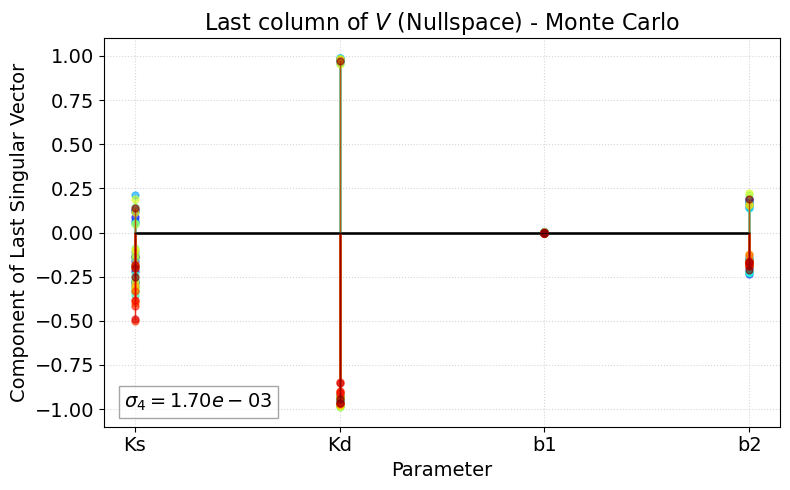

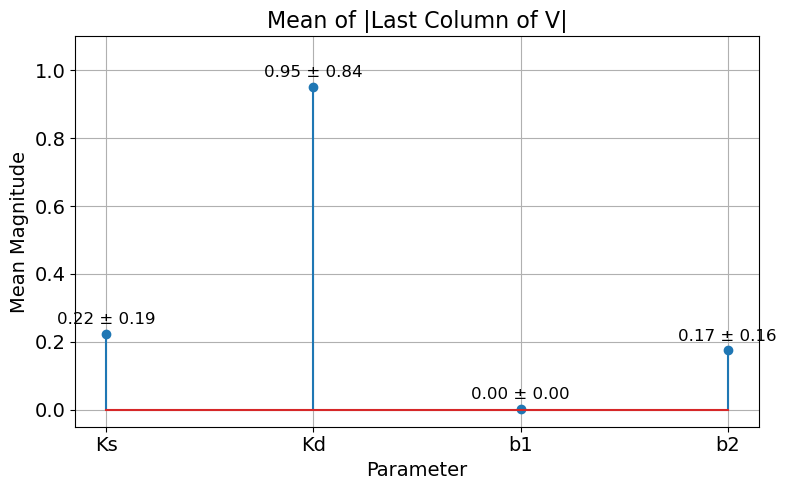

In [ ]:
# === General Configuration ===
theta_nom = np.array([0.5, 2.0, 0.6, 0.01, 2.0, 1.0])  # mu, Ks, Y, Kd, b1, b2
param_names = ['mu', 'Ks', 'Y', 'Kd', 'b1', 'b2']
Nth = len(theta_nom)
Nt = 10
Tf = 5.0
t_eval = np.linspace(0, Tf, Nt)
nx = 2
NExp = 10
threshold_sigma = 1e-3

# === Model Construction ===
def build_model(free_idx, theta_nom):
    n_free = len(free_idx)
    theta_free = ca.MX.sym("theta", n_free)
    theta_total = [0]*Nth
    for i in range(Nth):
        if i in free_idx:
            theta_total[i] = theta_free[free_idx.index(i)]
        else:
            theta_total[i] = theta_nom[i]
    mu, Ks, Y, Kd, b1, b2 = theta_total
    x = ca.MX.sym("x", nx)
    xdot = ca.vertcat(
        (mu * x[1] * x[0]) / (Ks + x[1]) - Kd * x[0],
        -(mu * x[1] * x[0]) / ((Ks + x[1]) * Y)
    )
    x0 = ca.vertcat(b1, b2)
    dx0 = ca.jacobian(x0, theta_free)
    Jx = ca.jacobian(xdot, x)
    Jth = ca.jacobian(xdot, theta_free)
    return {
        'f_rhs': ca.Function("rhs", [x, theta_free], [xdot]),
        'f_Jx': ca.Function("Jx", [x, theta_free], [Jx]),
        'f_Jth': ca.Function("Jth", [x, theta_free], [Jth]),
        'f_x0': ca.Function("x0", [theta_free], [x0]),
        'f_dx0': ca.Function("dx0", [theta_free], [dx0]),
        'free_idx': free_idx
    }

# === Single Simulation ===
def simulate_once(theta_val_free, model):
    x0_val = model['f_x0'](theta_val_free).full().flatten()
    dx0_val = model['f_dx0'](theta_val_free).full().reshape((nx, len(theta_val_free)))
    x_ext = np.concatenate([x0_val, dx0_val.flatten()])
    def rhs_meta(t, x_ext):
        x = x_ext[:nx]
        dx_dth = x_ext[nx:].reshape(nx, len(theta_val_free))
        A = model['f_Jx'](x, theta_val_free).full()
        B = model['f_Jth'](x, theta_val_free).full()
        dx = model['f_rhs'](x, theta_val_free).full().flatten()
        d_dx_dth = A @ dx_dth + B
        return np.concatenate([dx, d_dx_dth.flatten()])
    sol = solve_ivp(rhs_meta, [0, Tf], x_ext, t_eval=t_eval, method='BDF', rtol=1e-12, atol=1e-12)
    if not sol.success:
        raise RuntimeError("Integration failed")
    x_out = sol.y[:nx].T
    dx_dth_out = sol.y[nx:].T.reshape(Nt, nx, len(theta_val_free))
    return x_out, dx_dth_out

# === Sensitivity Calculation ===
def compute_dydth(x_out, dx_dth_out, theta_val_free):
    y_out = x_out[:, 0]
    dydth = dx_dth_out[:, 0, :]
    if np.any(y_out == 0):
        raise ValueError("❌ y_out contains zeros → division by zero")
    dydth_rel = dydth * theta_val_free.reshape(1, -1) / y_out.reshape(-1, 1)
    return dydth_rel

# === Combination Evaluation ===
def evaluate_combination(fixed_idx, theta_nom, NExp=50):
    if len(fixed_idx) == len(theta_nom):
        print(f"⛔️ Combination {fixed_idx} has all parameters fixed. Discarded.")
        return None
    free_idx = [i for i in range(Nth) if i not in fixed_idx]
    model = build_model(free_idx, theta_nom)
    THETA = np.random.uniform(0.5, 1.5, size=(NExp, Nth)) * theta_nom
    THETA[0] = theta_nom.copy()
    sigma_min_list = []
    v_last_list = []
    for k in range(NExp):
        theta_k = THETA[k].copy()
        theta_k[fixed_idx] = theta_nom[fixed_idx]
        theta_free = theta_k[free_idx]
        theta_nom_free = theta_nom[free_idx]
        try:
            x_out, dx_dth_out = simulate_once(theta_free, model)
            dydth_rel = compute_dydth(x_out, dx_dth_out, theta_nom_free)
            if np.any(np.isnan(dydth_rel)) or np.any(np.isinf(dydth_rel)):
                raise ValueError("NaNs or Infs")
            _, S, Vh = svd(dydth_rel, full_matrices=False)
            sigma_min_list.append(S[-1])
            v_last_list.append(np.abs(Vh[-1]))
        except Exception as e:
            print(f"❌ Error in combination {fixed_idx}: {e}")
            continue
    if len(sigma_min_list) == 0:
        return None
    sigma_min = np.min(sigma_min_list)
    v_last_array = np.array(v_last_list)
    mean_v = np.mean(v_last_array, axis=0)
    std_v = np.std(v_last_array, axis=0)
    print(f"🔍 Fix {[param_names[i] for i in fixed_idx]} → σ_min = {sigma_min:.2e}")
    return {
        'fixed': [param_names[i] for i in fixed_idx],
        'free': [param_names[i] for i in free_idx],
        'sigma_min': sigma_min,
        'mean_v': mean_v,
        'std_v': std_v
    }

# === Optimization Problem Definition ===
class IdentifiabilityProblem(Problem):
    def __init__(self, theta_nom, evaluate_combination, threshold_sigma=1e-3, NExp=50):
        self.theta_nom = theta_nom
        self.Nth = len(theta_nom)
        self.evaluate_combination = evaluate_combination
        self.threshold = threshold_sigma
        self.NExp = NExp
        self.evaluated = {}
        self.best_valid = None
        self.min_fixed_valid = None
        super().__init__(n_var=self.Nth, n_obj=1, xl=0, xu=1, type_var=np.bool_)

    def _evaluate(self, X, out, *args, **kwargs):
        F = []
        for i in range(X.shape[0]):
            key = tuple(X[i])
            if key in self.evaluated:
                F.append(self.evaluated[key])
                continue
            fixed_idx = [j for j in range(self.Nth) if X[i, j]]
            if self.min_fixed_valid is not None:
                if len(fixed_idx) > self.min_fixed_valid:
                    F.append(1e6 + len(fixed_idx))
                    self.evaluated[key] = F[-1]
                    continue
                elif len(fixed_idx) == self.min_fixed_valid and np.random.rand() > 0.2:
                    F.append(1e6 + len(fixed_idx))
                    self.evaluated[key] = F[-1]
                    continue
            res = self.evaluate_combination(fixed_idx, self.theta_nom, self.NExp)
            if res is None or res["sigma_min"] < self.threshold:
                F.append(1e6 + len(fixed_idx))
            else:
                F.append(len(fixed_idx))
                if self.min_fixed_valid is None or len(fixed_idx) < self.min_fixed_valid:
                    self.min_fixed_valid = len(fixed_idx)
                    self.best_valid = fixed_idx
                    print(f"✅ New optimum: {len(fixed_idx)} fixed → {res['fixed']}")
            self.evaluated[key] = F[-1]
        out["F"] = np.array(F)

# === Custom Sampling ===
class CustomSampling(Sampling):
    def _do(self, problem, n_samples, **kwargs):
        pop = np.random.randint(0, 2, size=(n_samples - 1, problem.n_var), dtype=bool)
        start = np.zeros(problem.n_var, dtype=bool).reshape(1, -1)
        return np.vstack([start, pop])

# === Optimization Execution ===
problem = IdentifiabilityProblem(theta_nom, evaluate_combination)
algorithm = GA(pop_size=3, eliminate_duplicates=True, sampling=CustomSampling())
termination = get_termination("n_gen", 10)
start_time3 = time.perf_counter()
res = minimize(problem, algorithm, termination, seed=1, verbose=True)
elapsed_time3 = time.perf_counter() - start_time3
print(f"\nSimulation time: {elapsed_time3:.3e} s.")
# === Output Best Solution ===
print("\n✅ Best combination found:")
fixed_idx = [i for i in range(problem.Nth) if res.X[i]]
print("Fixed parameters:", [param_names[i] for i in fixed_idx])
print("Score (number of fixed):", res.F[0])

# === Monte Carlo for Best Combination ===
free_idx = [i for i in range(problem.Nth) if not res.X[i]]
model = build_model(free_idx, theta_nom)
NExp = 50
THETA = np.random.uniform(0.5, 1.5, size=(NExp, Nth)) * theta_nom
THETA[0] = theta_nom.copy()
sigma_min_list = []
v_last_list = []

for k in range(NExp):
    theta_k = THETA[k].copy()
    theta_k[fixed_idx] = theta_nom[fixed_idx]
    theta_free = theta_k[free_idx]
    theta_nom_free = theta_nom[free_idx]
    try:
        x_out, dx_dth_out = simulate_once(theta_free, model)
        dydth_rel = compute_dydth(x_out, dx_dth_out, theta_nom_free)
        _, S, Vh = svd(dydth_rel, full_matrices=False)
        sigma_min_list.append(S[-1])
        v_last_list.append(Vh[-1])
    except:
        continue

# === Prepare Results for Plotting ===
SingularValues = np.array(sigma_min_list)
V_last_cols = np.array(v_last_list).T
mean_v = np.mean(np.abs(V_last_cols), axis=1)
std_v = np.std(V_last_cols, axis=1)
min_sigma = np.min(SingularValues)
param_names_free = [param_names[i] for i in free_idx]

# === Plot 1: Last column of V ===
colors = plt.cm.jet(np.linspace(0, 1, NExp))
x_vals = np.arange(len(param_names_free))
plt.figure(figsize=(8, 5))
for k in range(NExp):
    v_last = V_last_cols[:, k]
    markerline, stemlines, baseline = plt.stem(x_vals, v_last,
        linefmt='-', markerfmt='o', basefmt='k-')
    plt.setp(markerline, color=colors[k], markersize=5, alpha=0.6)
    plt.setp(stemlines, color=colors[k], linewidth=1, alpha=0.6)
    plt.setp(baseline, color='k', linewidth=0.8, alpha=0.5)
plt.xticks(x_vals, param_names_free, fontsize=14)
plt.yticks(fontsize=14)
plt.title(r"Last column of $V$ (Nullspace) - Monte Carlo", fontsize=16)
plt.xlabel("Parameter", fontsize=14)
plt.ylabel(r"Component of Last Singular Vector", fontsize=14)
plt.ylim(-1.1, 1.1)
plt.grid(True, linestyle=':', alpha=0.5)
plt.text(0.03, 0.05, r'$\sigma_{%d}=%.2e$' % (len(param_names_free), min_sigma),
         fontsize=14, transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', edgecolor='gray', alpha=0.7))
plt.tight_layout()
plt.show()

# === Plot 2: Mean of |last column of V| ===
plt.figure(figsize=(8, 5))
plt.stem(mean_v)
plt.xticks(x_vals, param_names_free, fontsize=14)
plt.yticks(fontsize=14)
for i in range(len(param_names_free)):
    plt.text(i, mean_v[i] + 0.02, f"{mean_v[i]:.2f} ± {std_v[i]:.2f}",
             ha='center', va='bottom', fontsize=12)
plt.title("Mean of |Last Column of V|", fontsize=16)
plt.xlabel("Parameter", fontsize=14)
plt.ylabel("Mean Magnitude", fontsize=14)
plt.ylim(-0.05, 1.1)
plt.grid(True)
plt.tight_layout()
plt.show()

Note: Depending on the model, it is important to tune the number of generations and population size accordingly.